In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords              
from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import os
print(os.listdir("../input"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['word2vec-nlp-tutorial', 'imdb-review-dataset']


In [2]:
raw_train_data_labeled = pd.read_csv("../input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip", header=0, delimiter="\t", quoting=3)
raw_train_data_unlabeled = pd.read_csv("../input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip", header=0, delimiter="\t", quoting=3)
raw_test_data = pd.read_csv("../input/word2vec-nlp-tutorial/testData.tsv.zip", header=0, delimiter="\t", quoting=3)

In [3]:
imdb_data = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding="latin-1")
imdb_data.head()


,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
imdb_data = imdb_data.drop(["Unnamed: 0","type","file"],axis=1)

In [5]:
imdb_data['sentiment'] = imdb_data['label'].map({"neg":0, "pos":1})

In [6]:
imdb_data = imdb_data.drop(["label"],axis=1)

In [7]:
imdb_data = imdb_data.dropna()

In [8]:
imdb_data = imdb_data[['sentiment','review']]

In [9]:
raw_train_data_labeled.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [10]:
raw_train_data_unlabeled.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [11]:
X = raw_train_data_labeled['review']
y = raw_train_data_labeled['sentiment']

In [12]:
review_data = pd.concat([X, raw_test_data['review']])

In [13]:
review_data = pd.concat([review_data, imdb_data['review']])

In [14]:
review_data

0        "With all this stuff going down at the moment ...
1        "\"The Classic War of the Worlds\" by Timothy ...
2        "The film starts with a manager (Nicholas Bell...
3        "It must be assumed that those who praised thi...
4        "Superbly trashy and wondrously unpretentious ...
                               ...                        
49995    Seeing as the vote average was pretty low, and...
49996    The plot had some wretched, unbelievable twist...
49997    I am amazed at how this movie(and most others ...
49998    A Christmas Together actually came before my t...
49999    Working-class romantic drama from director Mar...
Name: review, Length: 100000, dtype: object

In [15]:
review_data.shape

(100000,)

In [16]:
ntrain = X.shape[0]
df = pd.concat([raw_train_data_labeled, raw_test_data])
df = df.drop(['sentiment'], axis=1)
df_review = df['review']

In [17]:
import string

review_lines = list()
lines = review_data.values.tolist()

for line in lines:
    
    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)

In [18]:
import gensim

embedding_vector_size = 150
model_1 = gensim.models.Word2Vec(sentences = review_lines, vector_size=embedding_vector_size, min_count=1, window=5, workers=4 )
words = list(model_1.wv.key_to_index)

print("vocab size:", len(words))

vocab size: 135639


Text(0, 0.5, 'frequency')

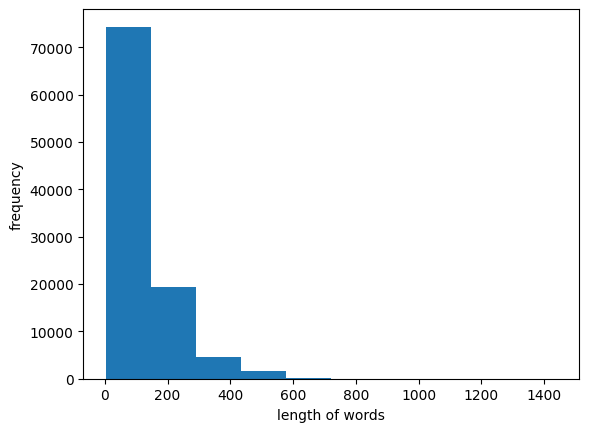

In [19]:
leng=0
length = [(leng + len(x)) for x in review_lines]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [20]:
import math
avg_length = sum(length)/len(review_lines)
print(avg_length)

122.12747


In [21]:
max_len = math.ceil(avg_length) 

In [22]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)  
train_test_data = review_lines                       
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [23]:
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
X = train_test_data[:ntrain,:]
X = np.append(X,train_test_data[ntrain+25000: ,:])
X = X.reshape(-1,123)
y1 = pd.concat([y, imdb_data['sentiment']])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X , y1, test_size=0.2, random_state=42, shuffle=True)

In [26]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = max_len, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [28]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 30, batch_size = 700, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 123, 150)          20346000  
                                                                 
 bidirectional (Bidirection  (None, 128)               110080    
 al)                                                             
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20457381 (78.04 MB)
Trainable params: 20457381 (78.04 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [29]:
y_test_pred = model.predict(X_test)

469/469 [==============================] - 29s 62ms/step


In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average = 'weighted')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

0.9763632451508162

In [31]:
y_pred = model.predict(train_test_data[ntrain:ntrain+25000 , :])

782/782 [==============================] - 49s 63ms/step


In [32]:
predictions = [1 if (x>0.5) else 0 for x in y_pred ]

In [33]:
predictions = pd.Series(predictions)

In [34]:
ids = raw_test_data['id'].str.replace('"', '')

In [35]:
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('submission.csv',index=False)